In [1]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import librosa
from tqdm.auto import tqdm

import random

In [2]:
sns.set_style("white")

In [83]:
pd.options.display.float_format = '{:.3f}'.format

In [3]:
FOLDER = '../input'
csv_path = os.path.join(FOLDER, 'training.csv')
sound_path = os.path.join(FOLDER, 'training')

In [4]:
df = pd.read_csv(csv_path)
df.head()

,device_id,filename,tightening_result_torque,junction_type,is_flange
0,2,00001.wav,65.4,j_c,0
1,2,00002.wav,82.4,j_b,0
2,3,00003.wav,75.0,j_b,1
3,2,00004.wav,105.0,j_a,0
4,3,00005.wav,99.8,j_d,0


In [5]:
df.shape

(1230, 5)

In [10]:
df.describe()

,device_id,tightening_result_torque,is_flange
count,1230.000000,1230.000000,1230.000000
mean,2.336585,76.591057,0.143902
std,0.472734,31.848536,0.351134
min,2.000000,14.800000,0.000000
25%,2.000000,53.400000,0.000000
50%,2.000000,76.800000,0.000000
75%,3.000000,98.200000,0.000000
max,3.000000,177.800000,1.000000


In [9]:
df.describe(include=object)

,filename,junction_type
count,1230,1230
unique,1230,4
top,00565.wav,j_a
freq,1,487


# Features

**Data Description**

name | description
---|---
device_id|IDs of the audio recorders used 
junction_type|four types of steel-to-steel connections
is_flange|flange is bolted point that joins a beam to a beam in the vertical direction
tightening_result_torque|target

## Target

Target distribution seems gaussian, MSE should be good metric for this task.

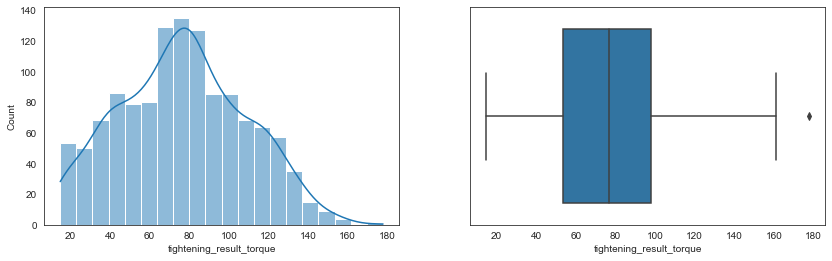

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df.tightening_result_torque, bins=20, kde=True, ax=axes[0]);
sns.boxplot(x=df.tightening_result_torque, ax=axes[1]);

## Additional Features

Seems like these features have some signal, using them in model may be good idea.

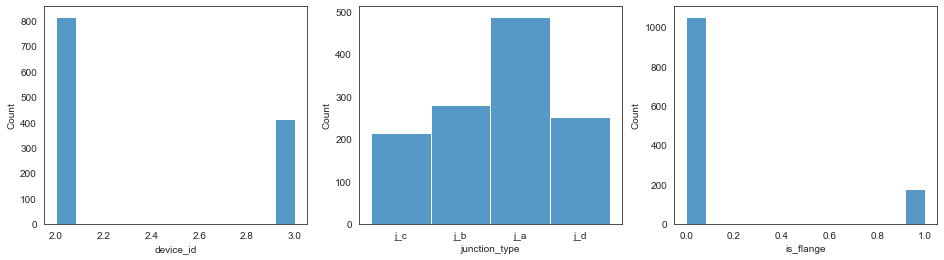

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(df.device_id, ax=axes[0])
sns.histplot(df.junction_type, ax=axes[1])
sns.histplot(df.is_flange, ax=axes[2]);

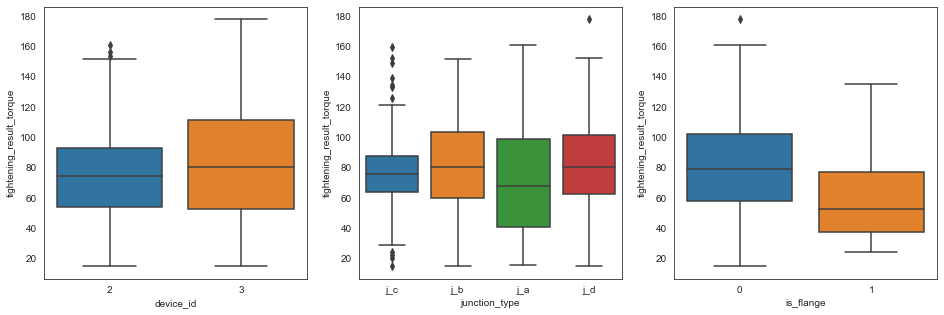

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.boxplot(x=df.device_id, y=df.tightening_result_torque, ax=axes[0])
sns.boxplot(x=df.junction_type, y=df.tightening_result_torque, ax=axes[1])
sns.boxplot(x=df.is_flange, y=df.tightening_result_torque, ax=axes[2]);

## Sound

In [37]:
SAMPLING_RATE = 192000

In [38]:
def read_file(path):
    """Read wav file"""
    wav, _ = librosa.core.load(path, sr=SAMPLING_RATE)
    return wav


def read_wav_files(path):
    """Read all wav files from directory"""
    features = []
    for filename in os.listdir(path):
        if filename.endswith(".wav"):
            wav = read_file(os.path.join(path, filename))
            features.append(wav)
    return features


def get_mel(wav):
    """Calculate melspectrogram"""
    melspec = librosa.feature.melspectrogram(
        wav,
        sr=SAMPLING_RATE,
        n_fft=2560,
        hop_length=355,
        n_mels=64
    )
    logmel = librosa.core.power_to_db(melspec)
    return logmel

In [39]:
data = read_wav_files(sound_path)
mel_specs = [get_mel(wav) for wav in data]

In [46]:
mel_specs[0].shape

(64, 595)

Audio values analysis

In [49]:
melt = np.concatenate(mel_specs, axis=1).ravel()

In [79]:
melt_wav = np.concatenate(data)

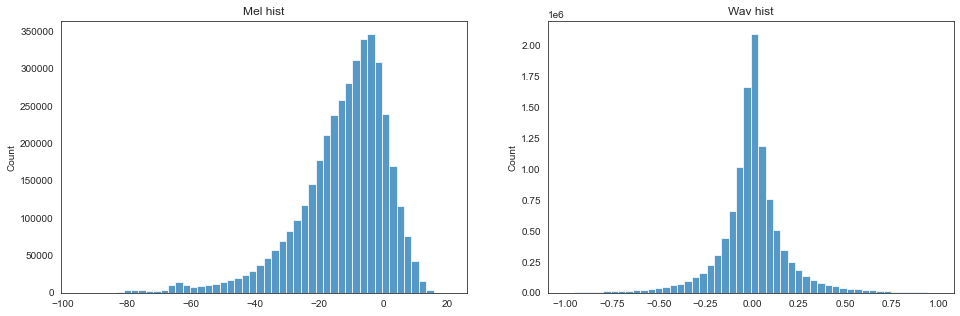

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(melt[::10], bins=50, ax=axes[0]).set_title("Mel hist")
sns.histplot(melt_wav[::20], bins=50, ax=axes[1]).set_title("Wav hist");

In [85]:
pd.Series(melt).describe()

count   39904640.000
mean         -12.548
std           14.270
min         -100.000
25%          -19.179
50%           -9.733
75%           -2.810
max           20.723
dtype: float64

In [84]:
pd.Series(melt_wav).describe()

count   221241600.000
mean           -0.000
std             0.186
min            -1.000
25%            -0.069
50%             0.000
75%             0.070
max             0.989
dtype: float64

Mel sample plot

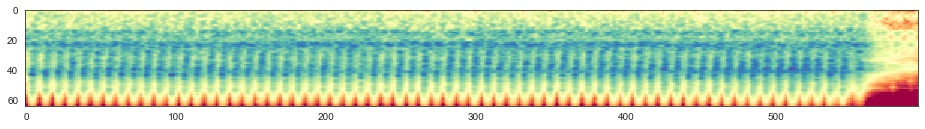

In [48]:
mel = get_mel(data[0])
fig, ax = plt.subplots(figsize=(16, 5))
ax.imshow(mel, cmap='Spectral', interpolation='nearest', vmin=mel.min(), vmax=mel.max());

Waveform sample plot

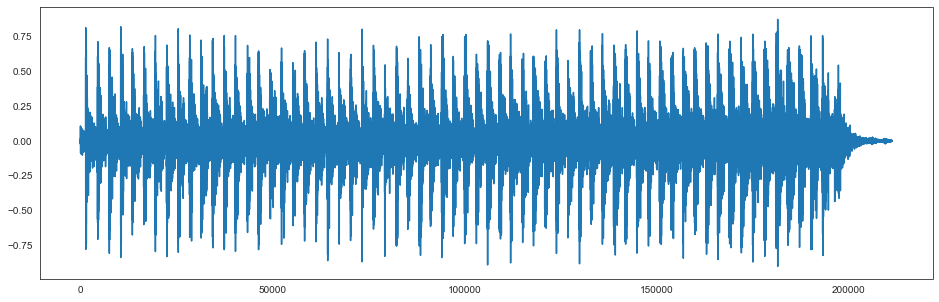

In [125]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(data[0]);

Wav lengths: most of them in 3 groups

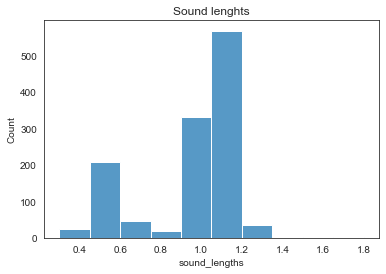

In [68]:
df['sound_lengths'] = np.array([len(wav)/SAMPLING_RATE for wav in data])
cplot = sns.histplot(df['sound_lengths'], bins=10);
cplot.set_title("Sound lenghts");

In [69]:
df['sound_lengths'].value_counts().head(3)

1.1    567
1.0    291
0.5    207
Name: sound_lengths, dtype: int64

In [72]:
top_len_mask = df['sound_lengths'].isin([1.1, 1.0, 0.5])

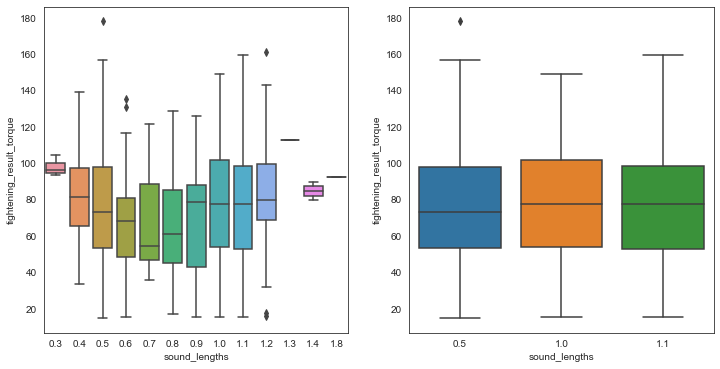

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
sns.boxplot(x=df['sound_lengths'], y=df['tightening_result_torque'], ax=axes[0]);
sns.boxplot(x=df.loc[top_len_mask, 'sound_lengths'], y=df.loc[top_len_mask, 'tightening_result_torque'], ax=axes[1]);

Let's generate some features

In [112]:
df['mel_max'] = [audio.max() for audio in mel_specs]
df['mel_min'] = [audio.min() for audio in mel_specs]
df['mel_median'] = [np.median(audio) for audio in mel_specs]
df['mel_mean'] = [audio.mean() for audio in mel_specs]
df['mel_std'] = [audio.std() for audio in mel_specs]

df['wave_max'] = [audio.max() for audio in data]
df['wave_min'] = [audio.min() for audio in data]
df['wave_median'] = [np.median(audio) for audio in data]
df['wave_mean'] = [audio.mean() for audio in data]
df['wave_std'] = [audio.std() for audio in data]

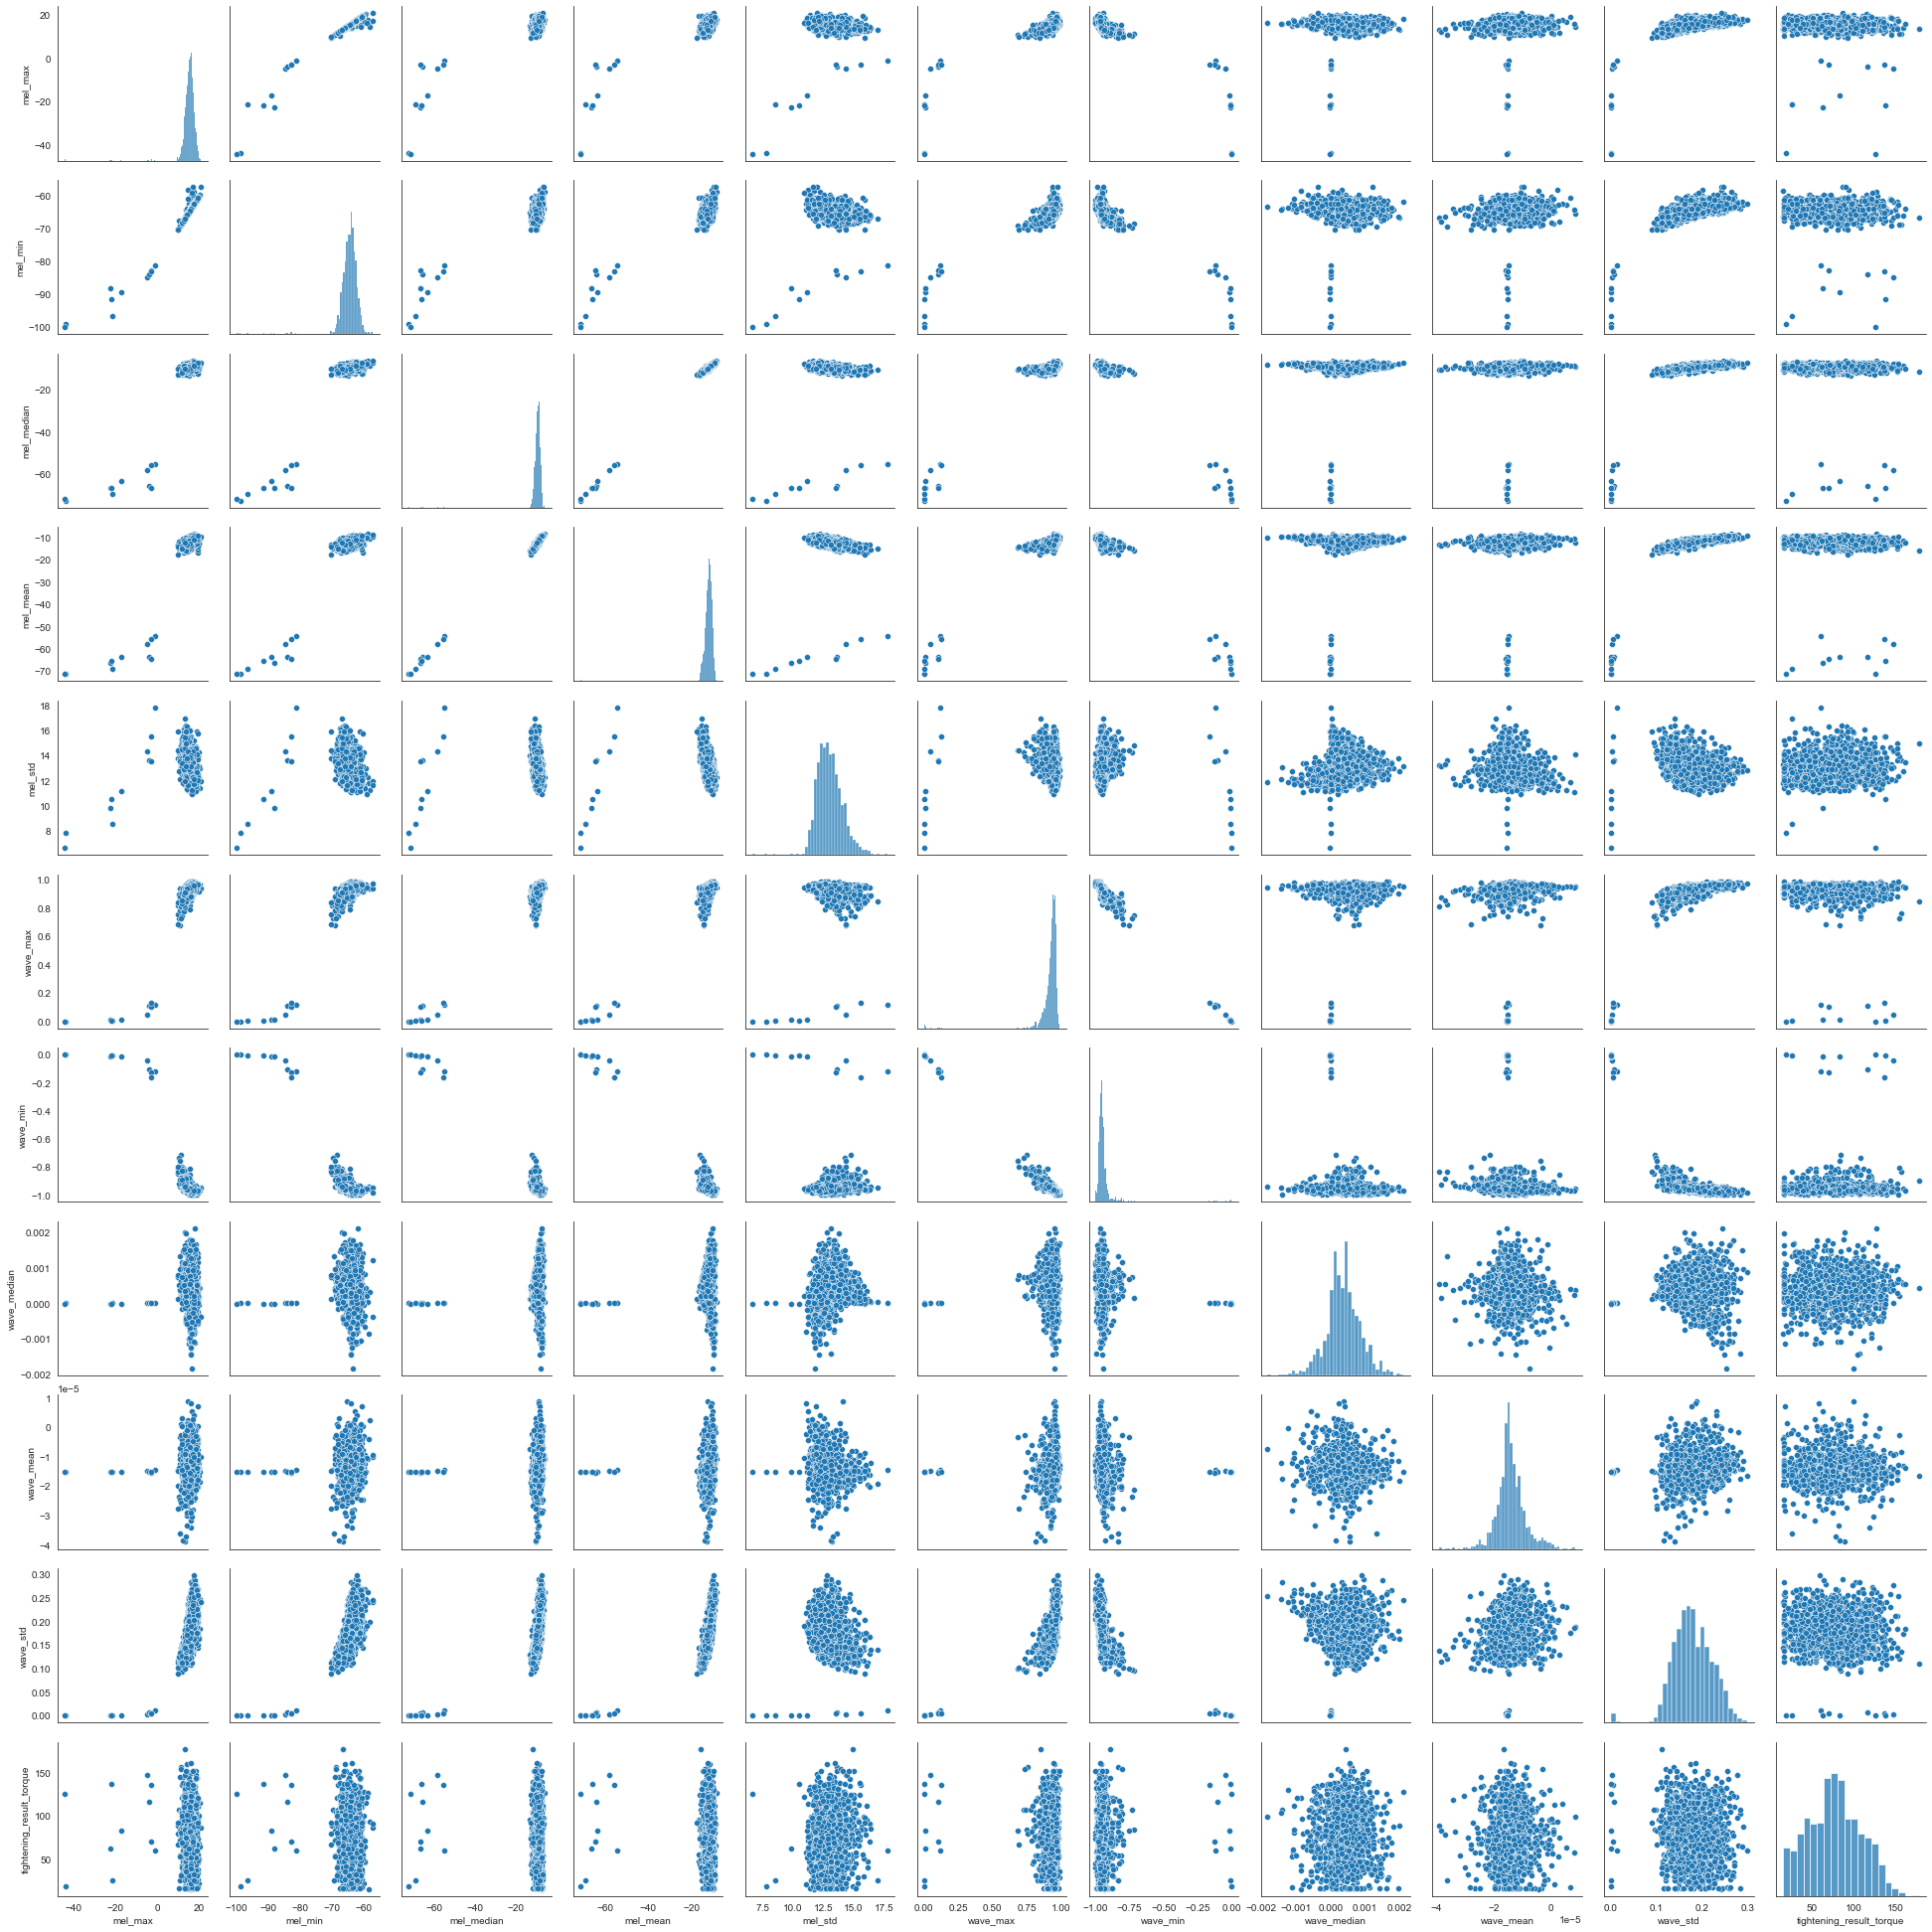

In [115]:
sns.pairplot(df[[
    'mel_max', 'mel_min', 'mel_median', 'mel_mean', 'mel_std', 
    'wave_max', 'wave_min', 'wave_median', 'wave_mean', 'wave_std', 
    'tightening_result_torque'
]])

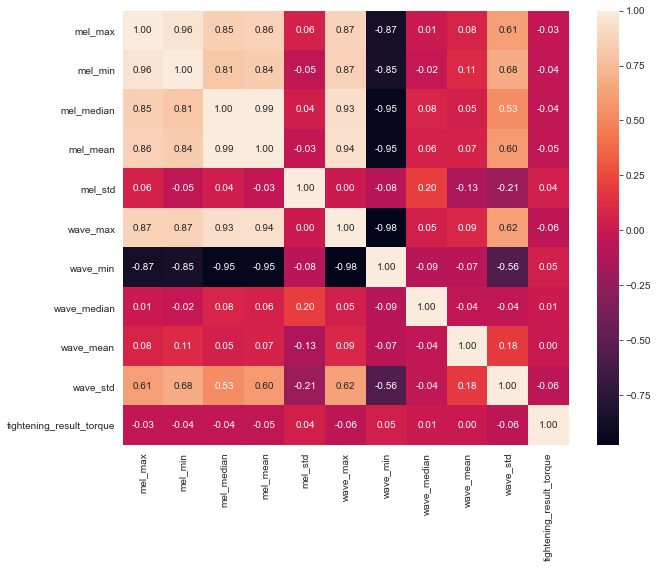

In [122]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[[
    'mel_max', 'mel_min', 'mel_median', 'mel_mean', 'mel_std', 
    'wave_max', 'wave_min', 'wave_median', 'wave_mean', 'wave_std', 
    'tightening_result_torque'
]].corr(), ax=ax, annot=True, fmt='.2f');

Sadly, but nothing correlates with target :(

## Outliers

There are some bad files without torque sound. Maybe it's better to remove them from training

In [97]:
low_std_idx = [df.index[i] for i in range(len(data)) if data[i].std() < 0.02]
low_std_name = [df['filename'].iloc[i] for i in range(len(data)) if data[i].std() < 0.02]
low_std_name

['00067.wav',
 '00226.wav',
 '00240.wav',
 '00260.wav',
 '00508.wav',
 '00836.wav',
 '00927.wav',
 '00929.wav',
 '01101.wav',
 '01113.wav',
 '01191.wav']

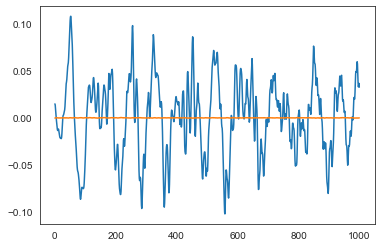

In [105]:
plt.plot(data[0][:1000])
plt.plot(data[low_std_idx[0]][:1000])

# Baseline

In [96]:
from sklearn.metrics import mean_squared_error

mean_squared_error(
    df.tightening_result_torque, 
    [df.tightening_result_torque.mean()] * len(df.tightening_result_torque),
    squared=False
)

31.835587307416574